In [1]:
pip install contractions wordninja

     |████████████████████████████████| 542kB 7.6MB/s 
     |████████████████████████████████| 327kB 14.7MB/s 
     |████████████████████████████████| 245kB 18.3MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp36-none-any.whl size=541553 sha256=b6870b49eee16e4105b15c28e6311ee77e0dc02e5ce0560ad4e479f895a75c11
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp36-cp36m-linux_x86_64.whl size=84340 sha256=89380193a42561d99a014f00bfe04d04435cfbaa5cb605d9ed9924fe981b82b2
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built wordninja pyahocorasick


In [2]:
import numpy as np
import pandas as pd
import json
import tweepy
import time
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from string import punctuation
import contractions
import re
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import random
import wordninja
import math

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

pd.set_option('display.max_colwidth',1000)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Preprocessing

In [ ]:
class TweetPreprocessing:
    def __init__(self, word_normalization):
      self.tokenizer = TweetTokenizer()
      self.stop_words = set(stopwords.words('english'))
      self.lemmatizer = WordNetLemmatizer()
      self.stemmer = PorterStemmer()
      self.ignore_words = ['..', '...', '’', '‘', '…', '“', '”', '', '⠀', '\x89', 'û_']

      if word_normalization in ['stemming', 'basic_lemmatization', 'pos_lemmatization']:
        self.word_normalization = word_normalization
      else:
        print('word_normalization parameter defaults to stemming')
        self.word_normalization = 'stemming'
      
    def unnest_lists(self, l):
      """
      Returns a flattened list from a list of tokens that may contain nested lists.
      Parameters:
          l: a list of tokens, some of which might be lists themselves
      """
      flattened_list = []
      for item in l: 
        if type(item) == list:
          for nested_item in item:
            flattened_list.append(nested_item)
        else: 
          flattened_list.append(item)
      
      return flattened_list
      
    def get_document_pos(self, tokenized_document):
      """
      Returns a document in the form of (word, tag) where each word is tupled with one of four tags that can be applied to lemmatization afterwards.
      Parameters:
          tokenized_document: a list of tokens
      """
      tagged_doc = nltk.pos_tag(tokenized_document)
      tag_dict = {"J": wordnet.ADJ,
                  "N": wordnet.NOUN,
                  "V": wordnet.VERB,
                  "R": wordnet.ADV}
      
      document_pos = [(tagged_word[0], tag_dict.get(tagged_word[1][0], wordnet.NOUN)) for tagged_word in tagged_doc]

      return document_pos

    def replace_hyperlinks(self, document):
      """
      Returns a copy of the document with removed hyperlinks and leading, trailing whitespaces removed.
      Parameters:
          document: a string
      """
      return re.sub(r"http\S+", "", document).strip()
    
    def preprocess_dataset(self, data):
      """
      Returns a copy of the original dataset with additional columns: text_preprocessed, duplicate_row.
      Parameters:
          data: a dataframe including columns for id, tweet text, target class
      """

      # remove hyperlinks and trim leading & trailing whitespaces
      data_preprocessed = data[['id', 'text', 'target']].copy()
      data_preprocessed['text_preprocessed'] = data_preprocessed['text'].apply(self.replace_hyperlinks)

      # mark duplicated rows
      data_preprocessed['duplicate_row'] = data_preprocessed.duplicated(subset=['text_preprocessed'], keep='first')
      
      return data_preprocessed

    def preprocess_document(self, document):
      """
      Returns array of tokens that correspond to the preprocessed document.
      Parameters:
          document: a string
      """

      # expand contractions (for example you`re => you are)
      doc_no_contractions = contractions.fix(document)

      # tokenize, make lower case and remove punctuation
      words = self.tokenizer.tokenize(doc_no_contractions)
      doc_no_punct = [w.lower() for w in words if w not in punctuation]

      # handle hashtags
      doc_no_hashtags = self.unnest_lists([wordninja.split(w[1:]) if w.startswith('#') else w for w in doc_no_punct])

      # lemmatization/stemming & stop words removal
      tokens_to_ignore = self.stop_words.union(set(self.ignore_words))
      
      doc_normalized = doc_no_hashtags
      if self.word_normalization == 'stemming':
        doc_normalized = [self.stemmer.stem(w) for w in doc_normalized if w not in tokens_to_ignore]
      elif self.word_normalization == 'basic_lemmatization':
        doc_normalized = [self.lemmatizer.lemmatize(w) for w in doc_normalized if w not in tokens_to_ignore]
      elif self.word_normalization == 'pos_lemmatization':
        doc_pos = self.get_document_pos(doc_normalized)
        doc_normalized = [self.lemmatizer.lemmatize(w, t) for (w, t) in doc_pos if w not in tokens_to_ignore]
      
      return doc_normalized
    

## Feature Ranking

In [ ]:
class FeatureRanking:
  def __init__(self, preprocesser, target_class=1):
    self.preprocesser = preprocesser
    self.target_class = target_class
    
    self.mi_rank = {} # dictionary to store mutual information ranking
    self.chi_sq_rank = {} # dictionary to chi square ranking

  def calculate(self, data, allow_duplicates=True):
    """
    Calculates mutual information and chi square for each word for the target class (self.target_class).
    Parameters:
        data: a dataframe including columns for id, tweet text, target class
        allow_duplicates: flag whether to include duplicate documents in calculations
    """

    # extract distinct classes
    classes = data['target'].unique()

    # preprocess the dataset
    data_preprocessed = self.preprocesser.preprocess_dataset(data)
    # preprocess each document, including tokenization
    data_tokenized = [(row['id'], self.preprocesser.preprocess_document(row['text_preprocessed']), row['target'])
      for index, row in data_preprocessed.iterrows() if allow_duplicates or not row['duplicate_row']]

    N = len(data_tokenized) # number of all documents
    N_by_class = {} # number of documents for each class
    word_doc_counts = Counter() # number of documents each word occurs in
    word_doc_counts_tc = Counter() # number of documents of the target class each word occurs in

    dictionary = set()
    # populate dictionary of words
    for doc in data_tokenized:
      for word in doc[1]:
        dictionary.add(word)

    for cl in classes:
      N_by_class[cl] = 0

    for doc in data_tokenized:
      cl = doc[2] # the class of the document
      
      # increment the number of documents of this class
      N_by_class[cl] += 1
      
      # update overall word-document occurrences
      word_doc_counts.update(set(doc[1]))
      if cl == self.target_class:
        # update word-document occurrences for this class
        word_doc_counts_tc.update(set(doc[1]))

    for word in dictionary:
      o11 = word_doc_counts_tc[word] # number of documents that contain the word and are of the target class
      o10 = word_doc_counts[word] - word_doc_counts_tc[word] # number of documents that contain the word and are not of the target class
      o01 = N_by_class[self.target_class] - o11 # number of documents that don`t contain the word and are of the target class
      o00 = N - N_by_class[self.target_class] - o10 # number of documents that don`t contain the word and are not of the target class

      o1_ = word_doc_counts[word] # number of documents that contain the word regardless of document class
      o0_ = N - word_doc_counts[word] # number of documents that don`t contain the word regardless of document class
      o_1 = N_by_class[self.target_class] # number of documents of the target class
      o_0 = N - N_by_class[self.target_class] # number of documents not of the target class

      # calculate mutual information
      self.mi_rank[word] = 0 if o11 == 0 else (o11/N)*math.log2(N*o11/(o1_*o_1)) + \
                           (o01/N)*math.log2(N*o01/(o0_*o_1)) + \
                           0 if o10 == 0 else (o10/N)*math.log2(N*o10/(o1_*o_0)) + \
                           (o00/N)*math.log2(N*o00/(o0_*o_0))
      
      # calculate chi square
      self.chi_sq_rank[word] = ((o11 + o10 + o01 + o00)*(o11*o00 - o10*o01)**2) / \
                                 ((o11 + o01)*(o11 + o10)*(o10 + o00)*(o01 + o00))


## Classifier

In [ ]:
class NaiveBayesDocumentClassifier:
  def __init__(self, preprocesser, vocabulary=None):
    self.dictionary = set() # dictionary of all tokens/words in the collection
    self.P_Vs = {} # prior target class probabilities
    self.P_words = {} # posterior word-class probabilities
    self.preprocesser = preprocesser
    self.vocabulary = vocabulary
  
  def fit(self, data, allow_duplicates=True):
    """
    Learns probabilites P(Wk|Vj) that describe the chance of a randomly selected word from a document classified as Vj to be the word Wk.
    Parameters:
        data: a dataframe including columns for id, tweet text, target class
        allow_duplicates: flag whether to include duplicate documents in calculations
    """
    
    # preprocess the dataset
    data_preprocessed = self.preprocesser.preprocess_dataset(data)
    # preprocess each document, including tokenization
    data_tokenized = [(row['id'], self.preprocesser.preprocess_document(row['text_preprocessed']), row['target'])
      for index, row in data_preprocessed.iterrows() if allow_duplicates or not row['duplicate_row']]
    
    # populate dictionary of words
    if self.vocabulary:
      self.dictionary = set(self.vocabulary)
    else:
      for doc in data_tokenized:
        for word in doc[1]:
          self.dictionary.add(word)

    N = len(data_tokenized) # number of all training examples (documents)
    n_dict = len(self.dictionary) # number of words in dictionary

    # iterate each class
    for V in data_preprocessed['target'].unique():
      docs_V = [d for d in data_tokenized if d[2] == V] # the set of documents of class V
      self.P_Vs[V] = len(docs_V)/N # calculate priori target class probabilities

      text_V = [word for doc in docs_V for word in doc[1]] # union of all documents of the class

      n_V = len(text_V) # number of all the words in text_V
      text_V_counts = Counter(text_V) # number of occurrences of each word in text_V

      for word in self.dictionary:
        n_word = text_V_counts[word] # number of occurrences of word in text_V
        self.P_words[(word, V)] = (n_word + 1)/(n_V + n_dict) # calculate probability of the word being of class V (Laplace smoothing included)


  def predict(self, document):
    """
    Predicts the class of a document.
    Parameters:
        document: a string that contains the document
    """
    
    # preprocess document
    doc_no_hyperlinks = self.preprocesser.replace_hyperlinks(document)
    doc_tokenized = self.preprocesser.preprocess_document(doc_no_hyperlinks)

    # store words from document that exist in classifier`s dictionary
    words_in_dictionary = [word for word in doc_tokenized if word in self.dictionary]

    p_V = 0
    max_p_V = 0
    output_V = -1

    # calculate probabilities for each class and store the final classification in output_V
    for V in self.P_Vs:
      p_word_V = 1

      # calculate the product of the probabilities of each word in the document to occur under class V
      for word in words_in_dictionary:
        p_word_V = p_word_V*self.P_words[(word, V)]
      
      # multiply the prior probability for the class with the posterior probability for each word
      p_V = self.P_Vs[V]*p_word_V
      
      # store the highest class probability
      if (p_V > max_p_V):
        max_p_V = p_V
        output_V = V
    
    return output_V

  def predict_proba(self, document):
    """
    Returns the probabilities of the document being of each class.
    Parameters:
        document: a string that contains the document
    """
    
    # preprocess document
    doc_no_hyperlinks = self.preprocesser.replace_hyperlinks(document)
    doc_tokenized = self.preprocesser.preprocess_document(doc_no_hyperlinks)

    # store words from document that exist in classifier`s dictionary
    words_in_dictionary = [word for word in doc_tokenized if word in self.dictionary]

    p_V = 0
    max_p_V = 0
    output_V = -1
    output_probs = []

    # calculate probabilities for each class and store the final classification in output_V
    for V in sorted(nb.P_Vs.keys()):
      p_word_V = 1

      # calculate the product of the probabilities of each word in the document to occur under class V
      for word in words_in_dictionary:
        p_word_V = p_word_V*self.P_words[(word, V)]
      
      # multiply the prior probability for the class with the posterior probability for each word
      p_V = self.P_Vs[V]*p_word_V
      
      # store the highest class probability
      if (p_V > max_p_V):
        max_p_V = p_V
        output_V = V
      
      # store probability
      output_probs.append(p_V)
    
    return output_probs/sum(output_probs)


## Classification stats - accuracy, precision, recall, F-score

In [ ]:
class ClassificationStats:
    def __init__(self, y_true, y_pred):
      self.cm = confusion_matrix(y_true, y_pred)
      self.tp = self.cm[1,1]
      self.tn = self.cm[0,0]
      self.fp = self.cm[0,1]
      self.fn = self.cm[1,0]

    def precision(self):
      """
      Returns the number of examples correctly classified as True, divided by the number of all examples classified as True.
      """
      return self.tp/(self.tp + self.fp)

    def recall(self):
      """
      Returns the number of examples correctly classified as True, divided by the number of all True examples.
      """
      return self.tp/(self.tp + self.fn)

    def accuracy(self):
      """
      Returns the number of correctly classified examples, divided by the number of all examples.
      """
      return (self.tp + self.tn)/(self.tp + self.fp + self.tn + self.fn)

    def f_measure(self, beta=1):
      """
      Returns the harmonic mean of precision and recall.
      Parameters:
          beta: controls the weighting of precision versus recall. For example, values of beta < 1 emphasize precision, while beta > 1 emphasize recall.
      """
      return ((beta**2 + 1)*self.precision()*self.recall()) / (beta**2*self.precision() + self.recall())



## Document similarity search

In [ ]:
class DocumentSimilaritySearch:
  def __init__(self):
    self.dictionary = None
    self.index = None

    self.stop_words = stopwords.words('english')
    self.ignore_words = ['..', '...', '’', '‘', '…', '“', '”', '', '⠀', '\x89', 'û_']

    self.vectorizer = TfidfVectorizer(lowercase=True, analyzer='word', stop_words=self.stop_words+self.ignore_words)

  def create_index(self, data, text_column='text_preprocessed'):
    """
    Calls fit() method of the vectorizer.
    Parameters:
        data: a dataframe in which text_column contains the data to be used for dictionary
    """
    self.dictionary = data[text_column]
    self.index = self.vectorizer.fit_transform(data[text_column])

  def find_similar_documents(self, query, n_documents):
    """
    Returns the top n_documents from the dictionary that are most similar to the query.
    Parameters:
        query: a string containing the query
        n_documents: number of documents to return
    """
    query_vec = self.vectorizer.transform([query])
    results = cosine_similarity(self.index, query_vec)

    top_n_indexes = [i[0] for i in np.argsort(results, axis=0)[-n_documents:][::-1]]

    return self.dictionary[top_n_indexes]

## Twitter streaming with classification

In [ ]:
class TwitterClassificationStreamListener(tweepy.StreamListener):
    def __init__(self, api, time_limit=60, classifier=None, prob_threshold=0):
        self.api = api
        self.me = api.me()
        self.tweets_list = []
        self.classifier = classifier
        self.prob_threshold = prob_threshold

        self.start_time = time.time()
        self.limit = time_limit

        super(TwitterClassificationStreamListener, self).__init__()

    def on_status(self, tweet):
      """
      Wait for Twitter posts and store each post in tweets_list. Run for the specified time limit.
      """
      if (time.time() - self.start_time) < self.limit:
        #print(tweet)
        if self.classifier:
          if self.prob_threshold > 0:
            prediction = self.classifier.predict_proba(tweet.text)
            if(prediction[1] >= self.prob_threshold): print(tweet.text)
          else:
            prediction = self.classifier.predict(tweet.text)            
            if(prediction == 1): print(tweet.text)

          self.tweets_list.append((tweet.text, prediction))
        return True
      else:
        return False

    def on_error(self, status):
        print("Error detected")

## Load data from file

In [ ]:
# load data from file
filepath = '/content/sample_data/train.csv'
data = pd.read_csv(filepath)
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Examples for the presentations

In [ ]:
data.groupby(['target']).target.count()/len(data)

target
0    0.57034
1    0.42966
Name: target, dtype: float64

In [ ]:
### File tweets.csv
### show examples of different disaster tweets, non-disaster tweets, strange data, etc.

# example of each of the four disaster events in the datasets
# The eruption of Taal Volcano in Batangas, Philippines
#data[['text', 'target']][data.index.isin([2998, 3264, 3290, 4110, 4140])]

# Coronavirus
#data[['text', 'target']][data.index.isin([7975, 7995, 8290, 8323])]

# Bushfires in Australia
#data[['text', 'target']][data.index.isin([453, 460, 471, 474, 2392])]

# Iran downing of the airplane flight PS752
data[['text', 'target']][data.index.isin([116, 120, 126, 131, 161])]

# Other
data[['text', 'target']][data.index.isin([11355, 11354, 11287, 11280, 11270])]

,text,target
11270,Are you trying to wreck me?? 😭😭😭,1
11280,"It's been 1 month since Ryan proposed to me and I'm still an absolute emotional wreck, cannot and will not stop cry… https://t.co/hPr3rBSmg5",1
11287,My nigha just called me and said he got in a wreck and his cuz in ICU. Shit I was having a good day. GOD bless my young FAME,1
11354,"Yeah, proper Liverpool fans wrecked Man City’s bus and the Heysel Stadium.",1
11355,"""Trump and Sisi 'rejected foreign exploitation and agreed that parties must take urgent steps to resolve the conflict before…",1


In [ ]:
### File train.csv
### show examples of different disaster tweets, non-disaster tweets, strange data, etc.

# example of each of the four disaster events in the datasets
# Keyword: demolition
data[['text', 'target']][data.id.isin([3379, 3368, 3365, 3397, 3401])]

# Keyword: explosion
data[['text', 'target']][data.id.isin([4957, 4980, 4962, 4968, 4988])]

# Keyword: landslide
data[['text', 'target']][data.id.isin([6675, 6686, 6683, 6681, 6690])]

# Other: wrong manual classification
data[['keyword', 'text', 'target']][data.id.isin([3369, 3398, 4966, 6654])]

# Other: incomplete tweet
data[['text', 'target']][data.id.isin([4528, 5650])]


,text,target
3154,Setting Up An Emergency Fund In 3 Easy Steps: You never know when a surprise expense will pop up. So work up t... http://t.co/Iz17kLelZC,0
3974,#flood #disaster Burst Water Pipe Floods Apartments at NYCHA Senior Center - NY1: NY1Burst Water Pipe Floods A... http://t.co/w7SIIdujOH,1


In [ ]:
### examples of hashtag split
print('#PantherAttack')
print(wordninja.split('#PantherAttack'), '\n')

print('#kidsthesedays')
print(wordninja.split('#kidsthesedays'), '\n')

print('#LegionnairesDisease')
print(wordninja.split('#LegionnairesDisease'), '\n')

print('#FlavorChargedTea')
print(wordninja.split('#FlavorChargedTea'), '\n')

#PantherAttack
['Panther', 'Attack'] 

#kidsthesedays
['kids', 'these', 'days'] 

#LegionnairesDisease
['Legionnaires', 'Disease'] 

#FlavorChargedTea
['Flavor', 'Charged', 'Tea'] 



In [ ]:
### examples of punctuation & stop words
print('Punctuation: ', punctuation, '\n')

print('Stop words:', len(stopwords.words('english')))
stopwords.words('english')

In [ ]:
# examples of stemming & lemmatization
tp = TweetPreprocessing(word_normalization='pos_lemmatization')
d = tp.preprocess_dataset(data.head())
data_tokenized = [(row['id'], tp.preprocess_document(row['text_preprocessed']), row['target']) for index, row in d.iterrows()]
print(data_tokenized)
d

[(1, ['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u'], 1), (4, ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'], 1), (5, ['resident', 'ask', 'shelter', 'place', 'notify', 'officer', 'evacuation', 'shelter', 'place', 'order', 'expect'], 1), (6, ['13,000', 'people', 'receive', 'wildfire', 'evacuation', 'order', 'california'], 1), (7, ['get', 'send', 'photo', 'ruby', 'alaska', 'smoke', 'wildfire', 'pour', 'school'], 1)]


,id,text,target,text_preprocessed,duplicate_row
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,False
1,4,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,False
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,False
3,6,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive #wildfires evacuation orders in California",False
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,False


In [ ]:
# examples of pos tagging
document = 'All residents asked to ''shelter in place'' are being notified by officers. No other evacuation or shelter in place orders are expected'
doc_no_contractions = contractions.fix(document)
words = tp.tokenizer.tokenize(doc_no_contractions)
doc_no_punct = [w.lower() for w in words if w not in punctuation]      
doc_no_hashtags = tp.unnest_lists([wordninja.split(w[1:]) if w.startswith('#') else w for w in doc_no_punct])
tokens_to_ignore = tp.stop_words.union(set(tp.ignore_words))
[d for d in doc_no_hashtags if d not in tokens_to_ignore]
[d for d in nltk.pos_tag(doc_no_hashtags) if d[0] not in tokens_to_ignore]
[d for d in tp.get_document_pos(doc_no_hashtags) if d[0] not in tokens_to_ignore]
tp.get_document_pos(doc_no_hashtags)

## Split data to train and validation sets

In [ ]:
seed = 1
data_shuffled = data.iloc[np.random.RandomState(seed=seed).permutation(len(data))]

train_fraction = 0.9
split_point = int(train_fraction *len(data_shuffled))
train_data = data_shuffled[0:split_point]
test_data = data_shuffled[split_point:]

tp = TweetPreprocessing(word_normalization='stemming')

###Apply feature ranking

In [ ]:
fr = FeatureRanking(tp)
fr.calculate(train_data)

### Initialize classifier and train

In [ ]:
vocab = None
#vocab = sorted(fr.mi_rank, key=fr.mi_rank.get, reverse=True)[:1000]
#vocab = sorted(fr.mi_rank, key=fr.mi_rank.get, reverse=True)[:5000]
#vocab = sorted(fr.mi_rank, key=fr.mi_rank.get, reverse=True)[:10000]

#vocab = sorted(fr.chi_sq_rank, key=fr.chi_sq_rank.get, reverse=True)[:1000]
#vocab = sorted(fr.chi_sq_rank, key=fr.chi_sq_rank.get, reverse=True)[:5000]
#vocab = sorted(fr.chi_sq_rank, key=fr.chi_sq_rank.get, reverse=True)[:10000]

nb = NaiveBayesDocumentClassifier(tp, vocabulary=vocab)
nb.fit(train_data)

### Initialize document search object and fit to create index

In [ ]:
ds = DocumentSimilaritySearch()
preprocessed_data = tp.preprocess_dataset(data)
ds.create_index(preprocessed_data)

In [ ]:
ds.find_similar_documents('Landslide in Hong Kong', 5)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


4678                                                                                         @kemal_atlay caught in a landslide
4704                                                                                      #landslide while on a trip in #skardu
4705                                                                               Listen to Landslide by Oh Wonder #SoundCloud
4703    So when you're caught in a landslide\nI'll be there for you\nAnd in the rain \ngive you sunshine\nI'll be there for you
5577                                                              Landslide caused by severe rainstorm kills 3 in ItalianåÊAlps
Name: text_preprocessed, dtype: object

### Use classifier to make predictions on validation set

In [ ]:
d = test_data.copy()
d['predict'] = d['text'].apply(nb.predict)

y_true = d['target']
y_pred = d['predict']

cs = ClassificationStats(y_true, y_pred)
print('Confusion matrix\n', cs.cm)
print('Precision: ', cs.precision())
print('Recall: ', cs.recall())
print('F-score ', cs.f_measure())
print('Accuracy ', cs.accuracy())

Confusion matrix
 [[377  56]
 [ 82 247]]
Precision:  0.8151815181518152
Recall:  0.7507598784194529
F-score  0.7816455696202531
Accuracy  0.8188976377952756


### Plot precision-recall curve for results on validation dataset

Text(0, 0.5, 'Precision')

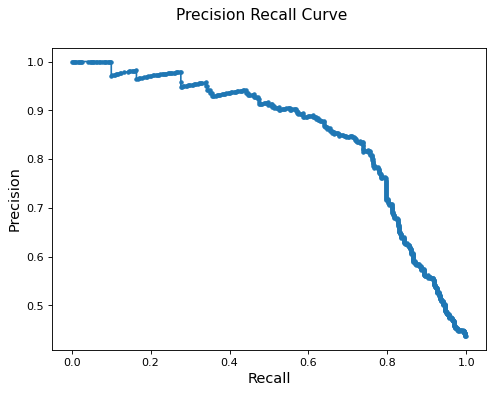

In [ ]:
from matplotlib import pyplot
from matplotlib.pyplot import figure

fig = figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Precision Recall Curve', fontsize=14)

d = test_data.copy()
d['predict_probs'] = d['text'].apply(nb.predict_proba)

y_true = d['target']
y_pred_probs = [dd[1] for dd in d['predict_probs']]

precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)
pyplot.plot(recall, precision, marker='.', label='NB')
pyplot.xlabel('Recall', fontsize=13)
pyplot.ylabel('Precision', fontsize=13)


### Show the words/tokens with highest probability to occur

In [ ]:
disaster_words = [(w[0], nb.P_words[w]) for w in nb.P_words if w[1] == 1]
non_disaster_words = [(w[0], nb.P_words[w]) for w in nb.P_words if w[1] == 0]
disaster_words.sort(key=(lambda x: x[1]), reverse=True)
non_disaster_words.sort(key=(lambda x: x[1]), reverse=True)

print('Most common words from disaster tweets')
print(disaster_words[0:10])
print('Most common words from non disaster tweets')
print(non_disaster_words[0:10])

Most common words from disaster tweets
[('fire', 0.00575363566348027), ('news', 0.004258596475331854), ('kill', 0.0032392515743215693), ('bomb', 0.0027409051782720972), ('get', 0.002491731980247361), ('via', 0.0024464277624246817), ('disaster', 0.0024464277624246817), ('suicide', 0.002355819326779323), ('storm', 0.0022878630000453043), ('people', 0.0022652108911339645)]
Most common words from non disaster tweets
[('get', 0.005765547827839936), ('like', 0.005362362665053926), ('go', 0.004334240499949602), ('new', 0.0033867553674024795), ('would', 0.002519907267412559), ('one', 0.002499748009273259), ('make', 0.0024594294929946576), ('want', 0.0023989517185767566), ('body', 0.002217518395323052), ('love', 0.0021167221046265497)]


### Apply Naive Bayes from sklearn for comparison

In [ ]:
import sklearn
import sklearn.naive_bayes

train_data_pp = tp.preprocess_dataset(train_data)
train_data_pp['tokenized_text'] = train_data_pp.text_preprocessed.apply(tp.preprocess_document).apply(lambda x: ' '.join(x))
# Convert to bag of words
count_vect = sklearn.feature_extraction.text.CountVectorizer(vocabulary=nb.dictionary)
X = count_vect.fit_transform(train_data_pp.tokenized_text)

# Convert from occurrences to frequencies
# Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.
# To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.
transformer = sklearn.feature_extraction.text.TfidfTransformer()
X = transformer.fit_transform(X)

# Create a model
model = sklearn.naive_bayes.MultinomialNB(alpha=0.3, fit_prior=True, class_prior=None)
# Train the model
model.fit(X, train_data_pp.target)

predictions = model.predict(X)
accuracy = sklearn.metrics.accuracy_score(train_data_pp.target, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))

test_data_pp = tp.preprocess_dataset(test_data)
test_data_pp['tokenized_text'] = test_data_pp.text_preprocessed.apply(tp.preprocess_document).apply(lambda x: ' '.join(x))

X = count_vect.transform(test_data_pp.tokenized_text)
X = transformer.transform(X)
predictions = model.predict(X)
accuracy = sklearn.metrics.accuracy_score(test_data_pp.target, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))

In [ ]:
consumerKey = '7gpSS06BU42kzp82QSh4dln5w'
consumerSecret = '7r8INlF8yjwDe8UmhklTXeGOF5L1YmEtS72NZtKOmbjfGTL94n'
token = '1273581727223554049-ruPO5HygK6CehA0rF98l1uMe8fJnaE'
secret = 'Gcdi8yOEHOwMBkN89AZr2WKVSqhdw3IYoZzVMTWRYWaRv'

## Run Twitter stream with classification

In [ ]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(token, secret)

# Create API object
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

tweets_listener = TwitterClassificationStreamListener(api, time_limit=5, classifier=nb, prob_threshold=0.8)
stream = tweepy.Stream(api.auth, tweets_listener)

tokens_to_track = [d[0] for d in disaster_words[0:5] if d[0] not in [nd[0] for nd in non_disaster_words[0:10]]]
stream.filter(track=tokens_to_track, languages=['en'])


RT @finebrownthang: @hecraveskay Nope. They start threatening to kill you &amp; themselves 😂🤷🏾‍♀️
RT @NEWSTALK1010: "He made a mistake" - Toronto Mayor says of travelling finance minister #onpoli #TOpoli https://t.co/POKXQKDbV6 https://t…
RT @imMAK02: One more encounter in Kashmir.

3 Kashmiri youth were killed by government forces in Srinagar Kashmir.

Families said they wer…
RT @Meidas_Kelly: So 1 day into my vacation and all I see is news about COVID. Death tolls, LA has no beds and 600 new cases an hour. At le…
RT @Resistance411: @JennaEllisEsq Never forget that Trump has hundreds of millions in loans from the state owned Bank of China 🇨🇳, and Ivan…
RT @MikayesFiona: BREAKING NEWS

SENATOR JOSH HAWLEY PUBLICLY STATES HE WILL OBJECT TO ELECTORS ON JAN 6!

ALL WE NEEDED WAS 1 AND WE HAVE…
RT @GuardianNigeria: Yobe earmarks N11.7b for road, market projects | The Guardian Nigeria News - Nigeria and World News https://t.co/fN0Yc…
RT @gkatz: Women often warn us about violent men. When wi

In [ ]:
query = [t[0] for t in tweets_listener.tweets_list if t[1] == 1]][0]
print(query)
#ds.find_similar_documents(query, 3)

## Load test dataset and apply classification

In [ ]:
# make predictions on test.csv
kaggle_test = pd.read_csv('/content/sample_data/test.csv')
kaggle_test['predict'] = kaggle_test['text'].apply(nb.predict)
kaggle_test[['id', 'predict']].to_csv(r'/content/sample_data/test_pred.csv', index = False)